# Experiments with the joining validator

In this notebook we experiment with different configurations of the joining validator. In the previous experiments we have been using the default configuration of the joining validator, namely a RandomForestClassifier with 100 trees and standard (adaptive) model parameters. In this notebook we will experiment with different configurations of the joining validator strategy, namely:

- Different classifiers: we will experiment with different classifiers, such as KNN, SVM, and MLP.
- One class classification and Outlier Detection models: Using different kinds of validator models from the basic classification scheme may have an effect?
- Different thresholds: we will experiment with different thresholds to see if privacy/utility trade-offs can be controlled.

Alltogether we hope to begin to answer the question; Wheather or not a better or worse performance of the joining validator is desired, what configurations should be used?

For the low level results, we will continue using the Hepatitis dataset split into categorical and numerical partitions, but for the high level results we will also explore other datasets. We will focus on the synthpop-ADSGAN DGM, because it has more room for improvement than the DataSynthesizer-DPGAN DGM.

## High level results

First, we will show the big experiment also presented in the paper. The figure shows all the datasets used in the study, with categorical and numerical partitions distributed to synthpop and ADSGAN respectively, and using different joining validators. The noteworthy results are highlighted in the figure.

/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-package

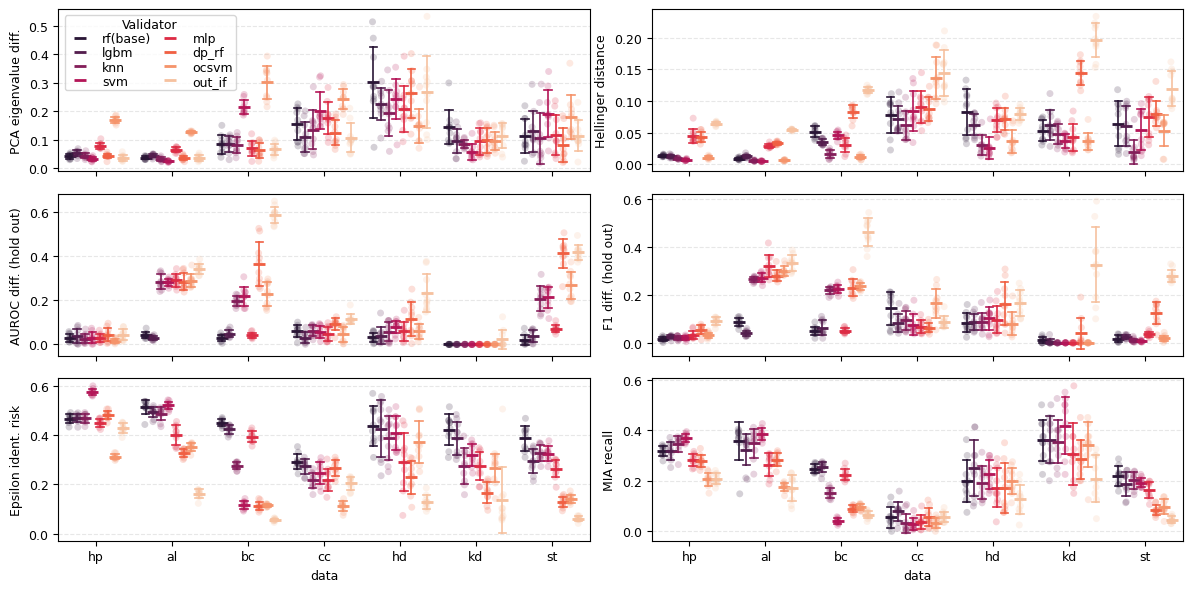

In [82]:

import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_validator_pointplot(datapath: str, metrics: Dict[str,str]) -> None:
    """ Function to plot a pointplot with mean results of the different validators for each metric."""

    df = pd.read_csv(datapath)

    validators = df['validator'].unique()
    df = df[['data', 'validator'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(len(metrics)//2, 2, figsize=(12, len(metrics)), sharex=True)

    colors = sns.color_palette("rocket", n_colors=len(validators))    

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.stripplot(
            data=df, x="data", y=metric, hue="validator",
            alpha=0.2, legend=False, palette=colors, dodge=True, ax=axes[i]
        )
        sns.pointplot(
            data=df, x="data", y=metric, hue="validator",
            linestyle="none", dodge=.8 - .8 / len(validators), err_kws={'linewidth':1.2}, capsize=0.1, errorbar='sd',
            palette=colors, markersize = 8, markers="_", ax=axes[i]
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        if i == 0:
            axes[i].legend(title="Validator", ncols=2, borderpad=0.2, labelspacing=0.1, columnspacing=0.5)
        else:
            axes[i].get_legend().remove()

    plt.tight_layout()
    plt.savefig("experiments/results/figures/validator_pointplot.pdf", bbox_inches='tight')
    plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "avg_h_dist": "Hellinger distance",
    "auroc": "AUROC diff. (hold out)",
    "cls_F1_diff_hout": "F1 diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

make_validator_pointplot("experiments/results/validator_case_study/full_validator_results.csv", metrics)

Based on this plot there seems to be no clear better choice than the random forest model with its default configuration, some models do better or worse on certain datasets, the differentially private random forest model, the one class svm, and outlier models stand out a bit doing generally better on privacy but worse on utility. More than any one classifier being a profoundly better choice, the results hint at the strictness/lenience of the joining validator impacting the trade-off between privacy and utility

This needs to be further investigated.

## Fixed threshold experiments

In the next series of experiments we use a the same validator models but affix the threshold at different positions. We will use the Hepatitis dataset for this experiment.

/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-package

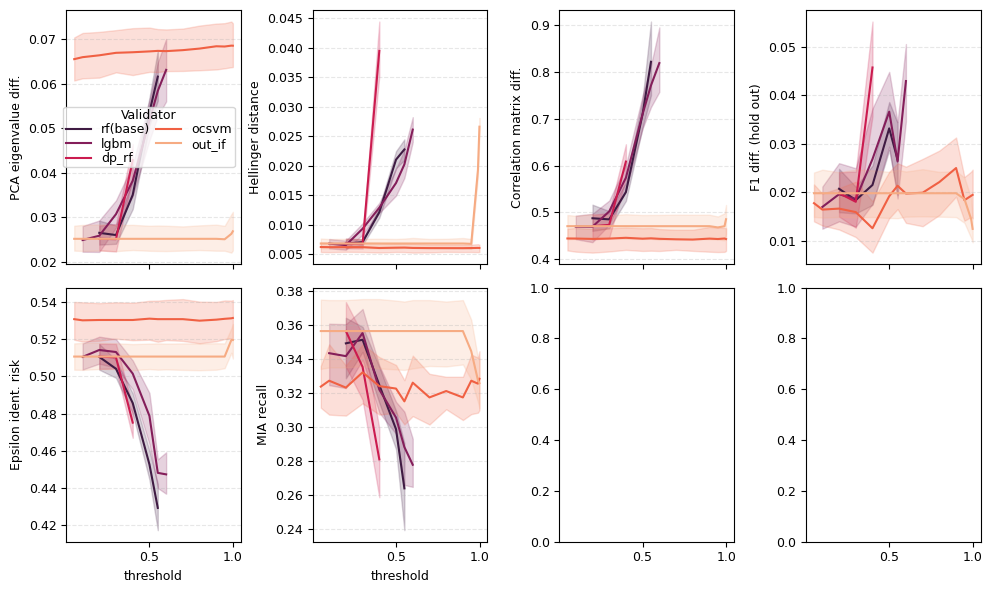

In [10]:
import numpy as np
import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_threshold_continuum_plot(datapath: str, dataset: str, valid_models: List[str], metrics: Dict[str,str]) -> None:
    """ This plot shows how the performance of different metrics vary 
    with using different validators at different threshold. """

    df = pd.read_csv(datapath)

    df = df[df['validator'].isin(valid_models)]
    df = df[df['data'] == dataset]
    df = df[['validator', 'threshold'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(int(np.ceil(len(metrics)/4)), 4, figsize=(10, 3*int((np.ceil(len(metrics)/4)))), sharex=True)

    colors = sns.color_palette("rocket", n_colors=len(valid_models))

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.lineplot(
            data=df, x="threshold", y=metric, hue="validator",
            palette=colors, ax=axes[i]
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        if i == 0:
            axes[i].legend(title="Validator", ncols=2, borderpad=0.2, labelspacing=0.1, columnspacing=0.5)
        else:
            axes[i].get_legend().remove()
    
    plt.tight_layout()
    plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "avg_h_dist": "Hellinger distance",
    "corr_mat_diff": "Correlation matrix diff.",
    "cls_F1_diff_hout": "F1 diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

make_threshold_continuum_plot("experiments/results/validator_case_study/full_threshold_results.csv", "hp", ["rf(base)", "lgbm", "dp_rf", "ocsvm", "out_if"], metrics)

In [2]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from syntheval import SynthEval

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator, OneClassValidator, OutlierValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

from experiments.auxiliaries.results_presentation import create_comparison_table
from experiments.auxiliaries.exp_repeater import repeated_experiment, repeated_experiment_timed

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

/home/lautrup/sdg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### Load data
df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

In [3]:
### Define evaluation
SE = SynthEval(df_train, df_test, verbose=False)

### Reload baseline
baseline = pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv')
baseline

,Unnamed: 0,mean,sem
0,pca_eigval_diff,0.279960,0.010220
1,pca_eigvec_ang,0.801992,0.081386
2,avg_h_dist,0.053954,0.003716
3,corr_mat_diff,1.543279,0.117489
4,auroc,0.019184,0.003032
5,cls_F1_diff,0.026126,0.004600
6,cls_F1_diff_hout,0.040952,0.005502
7,eps_identif_risk,0.032217,0.008490
8,priv_loss_eps,0.010498,0.003505
9,median_DCR,1.003361,0.028053


## OLD STUFF Different classifiers

We will start by experimenting with different classifiers. This experiment aims to explore if the default choice of the RandomForestClassifier is was justified, compared to other obvious choices.

### LightGBM

We will start by using the LightGBM classifier. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient and should propose a good competitor to the RandomForestClassifier.

In [3]:
from lightgbm import LGBMClassifier

In [ ]:
def lgbm(df_train: DataFrame, id: int = None) -> DataFrame:
    model = LGBMClassifier()

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, lgbm, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_dp_lgbm.csv')

In [5]:
print("Hepatitis (DS-DPGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', 
                        'experiments/results/validator_case_study/ds_dp_lgbm.csv', 
                        'RF validator', 'LGBM validator')

Hepatitis (DS-DPGAN) results:


,RF validator,LGBM validator,diff %,z_score,p_value
pca_eigval_diff,0.279960,0.246923,13.379647,1.553675,0.120262
pca_eigvec_ang,0.801992,0.808882,-0.851770,-0.068854,0.945106
avg_h_dist,0.053954,0.057842,-6.722027,-0.937948,0.348271
corr_mat_diff,1.543279,1.427585,8.104186,0.767514,0.442776
auroc,0.019184,0.039603,-51.559255,-1.756582,0.078989
cls_F1_diff,0.026126,0.171480,-84.764575,-19.018194,0.000000
cls_F1_diff_hout,0.040952,0.045018,-9.032593,-0.522757,0.601143
eps_identif_risk,0.032217,0.033846,-4.812834,-0.154825,0.876959
priv_loss_eps,0.010498,0.009683,8.411215,0.171780,0.863611
median_DCR,1.003361,1.003326,0.003475,0.001079,0.999139


### K-Nearest Neighbours

A K-Nearest Neighbours (KNN) classifier is a simple and interpretable model that is often used for binary classification tasks. Since odd joins will likely fall outside of a hyper-sphere of good joins, a KNN classifier might be a good choice for the joining validator.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
### Using KNN model with default parameters in joining model with standard behaviour
def knn_base(df_train: DataFrame, id: int = None) -> DataFrame:
    model = KNeighborsClassifier()

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, knn_base, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_dp_knn.csv')

In [4]:
print("Hepatitis (DS-DPGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', 
                        'experiments/results/validator_case_study/ds_dp_knn.csv', 
                        'RF validator', 'KNN validator')

Hepatitis (DS-DPGAN) results:


,RF validator,KNN validator,diff %,z_score,p_value
pca_eigval_diff,0.279960,0.357434,-21.674990,-1.895139,5.807399e-02
pca_eigvec_ang,0.801992,0.756248,6.048915,0.400435,6.888365e-01
avg_h_dist,0.053954,0.030777,75.304271,5.783069,7.335005e-09
corr_mat_diff,1.543279,1.616410,-4.524273,-0.440038,6.599095e-01
auroc,0.019184,0.023872,-19.640585,-0.609467,5.422150e-01
cls_F1_diff,0.026126,0.029627,-11.816812,-0.518935,6.038058e-01
cls_F1_diff_hout,0.040952,0.061226,-33.114116,-1.466614,1.424810e-01
eps_identif_risk,0.032217,0.037919,-15.035800,-0.442037,6.584627e-01
priv_loss_eps,0.010498,0.013484,-22.147651,-0.511691,6.088672e-01
median_DCR,1.003361,1.014710,-1.118405,-0.329032,7.421315e-01


In [ ]:
### Check the datasynthesizer-adsgan model also
def knn_base(df_train: DataFrame, id: int = None) -> DataFrame:
    model = KNeighborsClassifier()

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'adsgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, knn_base, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_ad_knn.csv')

In [4]:
print("Hepatitis (DS-ADSGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv', 
                        'experiments/results/validator_case_study/ds_ad_knn.csv', 
                        'RF validator', 'KNN validator')

Hepatitis (DS-ADSGAN) results:


,RF validator,KNN validator,diff %,z_score,p_value
pca_eigval_diff,0.040224,0.039339,2.248277,0.232306,8.163003e-01
pca_eigvec_ang,0.659892,0.723353,-8.773051,-0.874118,3.820542e-01
avg_h_dist,0.013285,0.011029,20.453425,2.049773,4.038655e-02
corr_mat_diff,0.599734,0.625231,-4.078011,-1.381356,1.671695e-01
auroc,0.025740,0.020087,28.140669,0.676938,4.984454e-01
cls_F1_diff,0.019792,0.018234,8.545799,0.399890,6.892374e-01
cls_F1_diff_hout,0.021821,0.018742,16.425619,0.654407,5.128494e-01
eps_identif_risk,0.464163,0.416742,11.378936,6.693666,2.176481e-11
priv_loss_eps,0.272398,0.228416,19.255151,6.438231,1.208738e-10
median_DCR,0.977541,0.989225,-1.181130,-2.811470,4.931565e-03


It appers that very few metrics are significantly improved by using the KNN classifier. Most noteworthy, it seems that H-distance is improved, which hints at KNN-based joining validator to be more faithful to maintain the marginal distributions. 

### Support Vector Machine

Support Vector Classifier models are powerful and flexible models based on the concept of finding a max-margin hyperplane. Counting from among simpler hyperplane models they are a good choice for more complex problems. 

In [5]:
from sklearn.svm import SVC

In [ ]:
### Using SVM model 
def svc_base(df_train: DataFrame, id: int = None) -> DataFrame:
    model = SVC(probability=True, gamma='auto')

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, svc_base, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_dp_svc.csv')

In [11]:
print("Hepatitis (DS-DPGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', 
                        'experiments/results/validator_case_study/ds_dp_svc.csv', 
                        'RF validator', 'SVC validator')

Hepatitis (DS-DPGAN) results:


,RF validator,SVC validator,diff %,z_score,p_value
pca_eigval_diff,0.279960,0.304642,-8.101920,-0.850060,0.395292
pca_eigvec_ang,0.801992,0.826453,-2.959711,-0.251692,0.801279
avg_h_dist,0.053954,0.059471,-9.277456,-1.334767,0.181953
corr_mat_diff,1.543279,1.710017,-9.750681,-1.124611,0.260754
auroc,0.019184,0.022871,-16.121936,-0.483611,0.628662
cls_F1_diff,0.026126,0.033188,-21.278696,-0.945738,0.344282
cls_F1_diff_hout,0.040952,0.043180,-5.160268,-0.248607,0.803664
eps_identif_risk,0.032217,0.026154,23.183391,0.595329,0.551624
priv_loss_eps,0.010498,0.011584,-9.375000,-0.231800,0.816693
median_DCR,1.003361,1.034999,-3.056751,-0.926339,0.354270


### Multi-Layer Perceptron

Multi-Layer Perceptron (MLP) models are neural network models for classification. This makes them very powerful, but also slower compared to the other baselines where untill now, the joining process has barely made a difference in the runtime.

In [4]:
from sklearn.neural_network import MLPClassifier

In [ ]:
def mlp_joining(df_train: DataFrame, id: int = None) -> DataFrame:
    model = MLPClassifier()

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, mlp_joining, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_dp_mlp.csv')

In [5]:
print("Hepatitis (DS-DPGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', 
                        'experiments/results/validator_case_study/ds_dp_mlp.csv', 
                        'RF validator', 'MLP validator')

Hepatitis (DS-DPGAN) results:


,RF validator,MLP validator,diff %,z_score,p_value
pca_eigval_diff,0.279960,0.260658,7.404931,0.726956,0.467253
pca_eigvec_ang,0.801992,0.798669,0.416157,0.032895,0.973758
avg_h_dist,0.053954,0.060962,-11.496305,-1.611969,0.106969
corr_mat_diff,1.543279,1.665419,-7.333886,-0.688772,0.490967
auroc,0.019184,0.025738,-25.466520,-1.174381,0.240242
cls_F1_diff,0.026126,0.175137,-85.082731,-18.315463,0.000000
cls_F1_diff_hout,0.040952,0.044363,-7.690041,-0.407411,0.683706
eps_identif_risk,0.032217,0.028959,11.250000,0.275010,0.783309
priv_loss_eps,0.010498,0.009050,16.000000,0.267145,0.789357
median_DCR,1.003361,1.020870,-1.715072,-0.526989,0.598201


In [ ]:
### Once again we repeat for the ADSGAN
def mlp_joining(df_train: DataFrame, id: int = None) -> DataFrame:
    model = MLPClassifier()

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'adsgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, mlp_joining, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_ad_mlp.csv')

In [6]:
print("Hepatitis (DS-ADSGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv', 
                        'experiments/results/validator_case_study/ds_ad_mlp.csv', 
                        'RF validator', 'MLP validator')

Hepatitis (DS-ADSGAN) results:


,RF validator,MLP validator,diff %,z_score,p_value
pca_eigval_diff,0.040224,0.087113,-53.825815,-8.091200,6.661338e-16
pca_eigvec_ang,0.659892,0.808105,-18.340802,-1.769530,7.680551e-02
avg_h_dist,0.013285,0.038203,-65.224468,-6.323862,2.551059e-10
corr_mat_diff,0.599734,1.118742,-46.392162,-8.961974,0.000000e+00
auroc,0.025740,0.034409,-25.194764,-0.848832,3.959750e-01
cls_F1_diff,0.019792,0.155962,-87.309513,-24.362013,0.000000e+00
cls_F1_diff_hout,0.021821,0.038951,-43.979226,-2.295778,2.168859e-02
eps_identif_risk,0.464163,0.323077,43.669468,18.929018,0.000000e+00
priv_loss_eps,0.272398,0.165611,64.480874,16.208547,0.000000e+00
median_DCR,0.977541,1.001386,-2.381176,-2.236390,2.532623e-02


Whereas there were no significant improvement for the DataSynthesizer-DPGAN model, the results appear to be better for privacy using this MLP model, it seems mainly to be because it is doing worse in general...

### Differential Privacy Classifier

The Differential Privacy Classifier is a classifier that is trained with differential privacy. This means that the classifier behaves as if it has not seen any one paticular sample in the dataset. Because only DPGAN has differential privacy and DataSynthesizer natively does not, using a differential privacy classifier for validation does not grant the differential privacy property to the final dataset, however, empirically, you would expect a drop in utility, why we here check if it can be further improved. 

In [4]:
from diffprivlib.models import RandomForestClassifier as DPRandomForestClassifier

In [ ]:
def dprf_joining(df_train: DataFrame, id: int = None) -> DataFrame:
    model = DPRandomForestClassifier(n_estimators=100, epsilon=0.2)

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, dprf_joining, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_dp_dprf.csv')

In [8]:
print("Hepatitis (DS-DPGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', 
                        'experiments/results/validator_case_study/ds_dp_dprf.csv', 
                        'RF validator', 'DPRF validator')

Hepatitis (DS-DPGAN) results:


,RF validator,DPRF validator,diff %,z_score,p_value
pca_eigval_diff,0.279960,0.264815,5.718885,0.396991,0.691374
pca_eigvec_ang,0.801992,0.836971,-4.179146,-0.350589,0.725897
avg_h_dist,0.053954,0.061904,-12.843253,-1.818426,0.068999
corr_mat_diff,1.543279,1.624758,-5.014860,-0.497386,0.618917
auroc,0.019184,0.027777,-30.936886,-0.948528,0.342861
cls_F1_diff,0.026126,0.181629,-85.615861,-16.516158,0.000000
cls_F1_diff_hout,0.040952,0.062112,-34.068061,-2.408936,0.015999
eps_identif_risk,0.032217,0.056833,-43.312102,-1.677933,0.093360
priv_loss_eps,0.010498,0.019276,-45.539906,-1.526828,0.126804
median_DCR,1.003361,1.010007,-0.658007,-0.172134,0.863332


In [ ]:
def dprf_joining(df_train: DataFrame, id: int = None) -> DataFrame:
    model = DPRandomForestClassifier(n_estimators=100, epsilon=0.2)

    JV = JoiningValidator(classifier_model_base=model)
    JS = UsingJoiningValidator(join_validator_model=JV, behaviour='standard')
    dgms = DisjointGenerativeModels(df_train, {'datasynthesizer': cat_atts, 'adsgan': num_atts}, joining_strategy=JS, worker_id=id)

    df_syn = dgms.fit_generate()
    return df_syn

res = repeated_experiment(df_train, df_test, label, dprf_joining, NUM_REPS, metrics)
res.to_csv('experiments/results/validator_case_study/ds_ad_dprf.csv')

In [7]:
print("Hepatitis (DS-ADSGAN) results:")
create_comparison_table('experiments/results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv', 
                        'experiments/results/validator_case_study/ds_ad_dprf.csv', 
                        'RF validator', 'DPRF validator')

Hepatitis (DS-ADSGAN) results:


,RF validator,DPRF validator,diff %,z_score,p_value
pca_eigval_diff,0.040224,0.042039,-4.317373,-0.474634,6.350480e-01
pca_eigvec_ang,0.659892,0.674776,-2.205713,-0.168027,8.665623e-01
avg_h_dist,0.013285,0.036242,-63.342999,-9.962567,0.000000e+00
corr_mat_diff,0.599734,0.632088,-5.118614,-1.682387,9.249378e-02
auroc,0.025740,0.032608,-21.063185,-0.686919,4.921335e-01
cls_F1_diff,0.019792,0.158305,-87.497285,-36.961665,0.000000e+00
cls_F1_diff_hout,0.021821,0.036725,-40.583840,-3.008519,2.625246e-03
eps_identif_risk,0.464163,0.471131,-1.479063,-1.077594,2.812151e-01
priv_loss_eps,0.272398,0.278733,-2.272727,-1.042983,2.969560e-01
median_DCR,0.977541,1.024028,-4.539669,-5.928170,3.063286e-09
